**<font color='blue'>The LendingClub is a peer-to-peer leading company that directly connects borrowers and potential lenders/investors. In this notebook, I will build a classification model to predict whether or not a loan provided by LendingClub is likely to default.**</font>

In [2]:
import pandas as pd
import numpy as np

## Load the datasets

In [3]:
loans = pd.read_csv('lending-club-data.csv')
loans.head(1)

//anaconda/lib/python2.7/site-packages/IPython/core/interactiveshell.py:2717: DtypeWarning: Columns (19,47) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


,id,member_id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,...,sub_grade_num,delinq_2yrs_zero,pub_rec_zero,collections_12_mths_zero,short_emp,payment_inc_ratio,final_d,last_delinq_none,last_record_none,last_major_derog_none
0,1077501,1296599,5000,5000,4975,36 months,10.65,162.87,B,B2,...,0.4,1.0,1.0,1.0,0,8.1435,20141201T000000,1,1,1


### Modifying the target column

In [4]:
#loans[['bad_loans', 'id']].groupby(['bad_loans']).aggregate('count')
loans['bad_loans'].value_counts()

0    99457
1    23150
Name: bad_loans, dtype: int64

In [6]:
# safe_loans =  1 => safe
# safe_loans = -1 => risky
loans['safe_loans'] = loans['bad_loans'].apply(lambda x : +1 if x==0 else -1)
loans = loans.drop('bad_loans', axis=1)

### Selecting features

Lets use a subset of features

In [7]:
target = 'safe_loans'
features = ['grade',                     # grade of the loan (categorical)
            'sub_grade_num',             # sub-grade of the loan as a number from 0 to 1
            'short_emp',                 # one year or less of employment
            'emp_length_num',            # number of years of employment
            'home_ownership',            # home_ownership status: own, mortgage or rent
            'dti',                       # debt to income ratio
            'purpose',                   # the purpose of the loan
            'payment_inc_ratio',         # ratio of the monthly payment to income
            'delinq_2yrs',               # number of delinquincies
             'delinq_2yrs_zero',          # no delinquincies in last 2 years
            'inq_last_6mths',            # number of creditor inquiries in last 6 months
            'last_delinq_none',          # has borrower had a delinquincy
            'last_major_derog_none',     # has borrower had 90 day or worse rating
            'open_acc',                  # number of open credit accounts
            'pub_rec',                   # number of derogatory public records
            'pub_rec_zero',              # no derogatory public records
            'revol_util',                # percent of available credit being used
            'total_rec_late_fee',        # total late fees received to day
            'int_rate',                  # interest rate of the loan
            'total_rec_int',             # interest received to date
            'annual_inc',                # annual income of borrower
            'funded_amnt',               # amount committed to the loan
            'funded_amnt_inv',           # amount committed by investors for the loan
            'installment',               # monthly payment owed by the borrower
           ]

In [8]:
loans = loans[[target] + features].dropna()

In [9]:
loans.shape

(122578, 25)

### One-hot encoding

In [10]:
loans = pd.get_dummies(loans)

In [11]:
loans.shape

(122578, 45)

### Split into train and validation sets

In [12]:
train_idx = pd.read_json('./module-8-assignment-1-train-idx.json')
validation_idx = pd.read_json('./module-8-assignment-1-validation-idx.json')
train_idx.shape, validation_idx.shape

((37219, 1), (9284, 1))

In [13]:
train_data = loans.iloc[train_idx[0]]
validation_data = loans.iloc[validation_idx[0]]

In [14]:
train_data.shape, validation_data.shape, loans.shape

((37219, 45), (9284, 45), (122578, 45))

Note. Some elements in loans are included neither in train_data nor validation_data. This is to perform sampling to achieve class balance. Below shows they are much more balanced now.

In [15]:
train_data['safe_loans'].value_counts(1), validation_data['safe_loans'].value_counts(1)

( 1    0.503614
 -1    0.496386
 Name: safe_loans, dtype: float64, -1    0.503231
  1    0.496769
 Name: safe_loans, dtype: float64)

### Gradient boosted tree classifier

Gradient boosted trees are a powerful variant of boosting methods; they have been used to win many Kaggle competitions, and have been widely used in industry. We will explore the predictive power of multiple decision trees as opposed to a single decision tree.

Additional reading:

[Advanced material on boosted trees](http://homes.cs.washington.edu/~tqchen/pdf/BoostedTree.pdf)

[sklearn Gradient Boosting](http://scikit-learn.org/stable/modules/generated/sklearn.ensemble.GradientBoostingClassifier.html)


In [16]:
import sklearn, sklearn.ensemble

In [17]:
max_depth=6
n_estimators=5

In [18]:
gbt = sklearn.ensemble.GradientBoostingClassifier(n_estimators=n_estimators, max_depth=max_depth)

In [19]:
gbt.fit(train_data.drop('safe_loans', axis=1), train_data['safe_loans'])

GradientBoostingClassifier(init=None, learning_rate=0.1, loss='deviance',
              max_depth=6, max_features=None, max_leaf_nodes=None,
              min_samples_leaf=1, min_samples_split=2,
              min_weight_fraction_leaf=0.0, n_estimators=5, presort='auto',
              random_state=None, subsample=1.0, verbose=0,
              warm_start=False)

### Making predictions

First, let's grab 2 positive examples and 2 negative examples. 

In [20]:
validation_safe_loans = validation_data[validation_data[target] == 1]
validation_risky_loans = validation_data[validation_data[target] == -1]

sample_validation_data_risky = validation_risky_loans[0:2]
sample_validation_data_safe = validation_safe_loans[0:2]

sample_validation_data = sample_validation_data_safe.append(sample_validation_data_risky)
sample_validation_data

,safe_loans,sub_grade_num,short_emp,emp_length_num,dti,payment_inc_ratio,delinq_2yrs,delinq_2yrs_zero,inq_last_6mths,last_delinq_none,...,purpose_debt_consolidation,purpose_home_improvement,purpose_house,purpose_major_purchase,purpose_medical,purpose_moving,purpose_other,purpose_small_business,purpose_vacation,purpose_wedding
22,1,0.2,0,3,29.44,6.30496,0.0,1.0,0.0,1,...,0,0,0,0,0,0,0,0,0,0
26,1,0.6,1,1,12.19,13.49520,0.0,1.0,0.0,1,...,0,0,0,0,0,0,0,0,0,0
24,-1,0.4,0,3,13.97,2.96736,3.0,0.0,0.0,0,...,0,0,0,0,0,0,1,0,0,0
41,-1,1.0,0,11,16.33,1.90524,0.0,1.0,0.0,1,...,1,0,0,0,0,0,0,0,0,0


In [21]:
prediction = gbt.predict(sample_validation_data.drop('safe_loans', axis=1))

In [22]:
prediction

array([ 1,  1, -1,  1])

In [23]:
import sklearn.metrics
sklearn.metrics.accuracy_score(sample_validation_data['safe_loans'], prediction)

0.75

In [24]:
gbt.predict_proba(sample_validation_data.drop('safe_loans', axis=1)) #probability of being -1 and 1

array([[ 0.41642331,  0.58357669],
       [ 0.46949689,  0.53050311],
       [ 0.53807792,  0.46192208],
       [ 0.39591639,  0.60408361]])

In [26]:
prediction = gbt.predict(validation_data.drop('safe_loans', axis=1))
sklearn.metrics.accuracy_score(validation_data['safe_loans'], prediction)

0.66146057733735464

In [27]:
sklearn.metrics.confusion_matrix(validation_data['safe_loans'], prediction)

array([[3020, 1652],
       [1491, 3121]])

Accuracy of 0.66 is better than what we got for Decision Tree, which had 0.64

### Cost of mistakes

False negatives: Assume a cost of $10,000 per false negative.

False positives: Assume a cost of $20,000 per false positive.

In [29]:
false_negatives = 1491
false_positives = 1652
Cost = 10000 * false_negatives + 20000 * false_positives
Cost

47950000

### Most positive & negative loans

In [30]:
probability_predictions = gbt.predict_proba(validation_data.drop('safe_loans', axis=1)) #probability of being -1 and 1

In [33]:
probability_predictions.shape, validation_data.shape

((9284, 2), (9284, 45))

In [42]:
probability_predictions[:,1] #probability of predicting as safe

array([ 0.46192208,  0.60408361,  0.47987242, ...,  0.46469023,
        0.47719076,  0.46192208])

In [53]:
validation_data['probability_predictions'] = probability_predictions[:,1]
validation_data.sort_values('probability_predictions', ascending=False).head(5)

/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


,safe_loans,sub_grade_num,short_emp,emp_length_num,dti,payment_inc_ratio,delinq_2yrs,delinq_2yrs_zero,inq_last_6mths,last_delinq_none,...,purpose_home_improvement,purpose_house,purpose_major_purchase,purpose_medical,purpose_moving,purpose_other,purpose_small_business,purpose_vacation,purpose_wedding,probability_predictions
8021,-1,0.4,0,4,12.73,12.16700,0.0,1.0,1.0,1,...,0,0,0,0,0,0,0,0,0,0.673059
109930,1,0.4,0,4,13.75,2.03093,0.0,1.0,1.0,1,...,0,0,0,0,0,0,0,0,0,0.661468
10689,1,0.4,0,5,7.82,1.12313,0.0,1.0,1.0,1,...,1,0,0,0,0,0,0,0,0,0.661468
13391,1,0.2,0,2,8.18,6.03200,0.0,1.0,0.0,1,...,0,0,0,0,0,1,0,0,0,0.661468
89078,1,0.4,0,11,14.95,2.26242,0.0,1.0,1.0,1,...,0,0,0,0,0,0,0,0,0,0.661468


In [54]:
validation_data.sort_values('probability_predictions', ascending=False).tail(5)

,safe_loans,sub_grade_num,short_emp,emp_length_num,dti,payment_inc_ratio,delinq_2yrs,delinq_2yrs_zero,inq_last_6mths,last_delinq_none,...,purpose_home_improvement,purpose_house,purpose_major_purchase,purpose_medical,purpose_moving,purpose_other,purpose_small_business,purpose_vacation,purpose_wedding,probability_predictions
114781,-1,0.4,0,3,21.90,7.18760,1.0,0.0,4.0,0,...,0,0,0,0,0,0,0,0,0,0.315969
101746,-1,0.2,0,11,11.21,4.23624,0.0,1.0,3.0,1,...,0,0,1,0,0,0,0,0,0,0.315969
27502,-1,1.0,0,3,8.53,14.62800,0.0,1.0,0.0,1,...,1,0,0,0,0,0,0,0,0,0.312806
58794,-1,0.8,0,2,8.66,17.62510,0.0,1.0,0.0,1,...,0,0,0,0,0,0,0,0,0,0.307334
84508,-1,0.8,1,1,7.37,16.62070,0.0,1.0,1.0,1,...,0,0,0,0,0,0,0,0,0,0.307334


### Effects of adding more trees

In [55]:
model_10 = sklearn.ensemble.GradientBoostingClassifier(n_estimators=10, max_depth=max_depth)
model_50 = sklearn.ensemble.GradientBoostingClassifier(n_estimators=50, max_depth=max_depth)
model_100 = sklearn.ensemble.GradientBoostingClassifier(n_estimators=100, max_depth=max_depth)
model_200 = sklearn.ensemble.GradientBoostingClassifier(n_estimators=200, max_depth=max_depth)
model_500 = sklearn.ensemble.GradientBoostingClassifier(n_estimators=500, max_depth=max_depth)

In [56]:
model_10.fit(train_data.drop('safe_loans', axis=1), train_data['safe_loans'])
model_50.fit(train_data.drop('safe_loans', axis=1), train_data['safe_loans'])
model_100.fit(train_data.drop('safe_loans', axis=1), train_data['safe_loans'])
model_200.fit(train_data.drop('safe_loans', axis=1), train_data['safe_loans'])
model_500.fit(train_data.drop('safe_loans', axis=1), train_data['safe_loans'])

GradientBoostingClassifier(init=None, learning_rate=0.1, loss='deviance',
              max_depth=6, max_features=None, max_leaf_nodes=None,
              min_samples_leaf=1, min_samples_split=2,
              min_weight_fraction_leaf=0.0, n_estimators=500,
              presort='auto', random_state=None, subsample=1.0, verbose=0,
              warm_start=False)

In [61]:
prediction = model_10.predict(validation_data.drop(['safe_loans', 'probability_predictions'], axis=1))
print "Gradient Boosting Prediction using 10 estimators is: %.3f " %sklearn.metrics.accuracy_score(validation_data['safe_loans'], prediction)
prediction = model_50.predict(validation_data.drop(['safe_loans', 'probability_predictions'], axis=1))
print "Gradient Boosting Prediction using 50 estimators is: %.3f " %sklearn.metrics.accuracy_score(validation_data['safe_loans'], prediction)
prediction = model_100.predict(validation_data.drop(['safe_loans', 'probability_predictions'], axis=1))
print "Gradient Boosting Prediction using 100 estimators is: %.3f " %sklearn.metrics.accuracy_score(validation_data['safe_loans'], prediction)
prediction = model_200.predict(validation_data.drop(['safe_loans', 'probability_predictions'], axis=1))
print "Gradient Boosting Prediction using 200 estimators is: %.3f " %sklearn.metrics.accuracy_score(validation_data['safe_loans'], prediction)
prediction = model_500.predict(validation_data.drop(['safe_loans', 'probability_predictions'], axis=1))
print "Gradient Boosting Prediction using 500 estimators is: %.3f " %sklearn.metrics.accuracy_score(validation_data['safe_loans'], prediction)

Gradient Boosting Prediction using 10 estimators is: 0.666 
Gradient Boosting Prediction using 50 estimators is: 0.685 
Gradient Boosting Prediction using 100 estimators is: 0.689 
Gradient Boosting Prediction using 200 estimators is: 0.690 
Gradient Boosting Prediction using 500 estimators is: 0.689 


### Plot the training and validation error vs. number of trees

[classification error]=1−[accuracy]

In [64]:
import matplotlib.pyplot as plt
%matplotlib inline
def make_figure(dim, title, xlabel, ylabel, legend):
    plt.rcParams['figure.figsize'] = dim
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    if legend is not None:
        plt.legend(loc=legend, prop={'size':15})
    plt.rcParams.update({'font.size': 16})
    plt.tight_layout()

In [67]:
training_errors = []

In [69]:
models = [model_10, model_50, model_100, model_200, model_500]
for model in models:
    prediction = model.predict(train_data.drop(['safe_loans'], axis=1))
    error = 1 - sklearn.metrics.accuracy_score(train_data['safe_loans'], prediction)
    training_errors.append(error)
training_errors

[0.32832692979392242,
 0.28270506999113354,
 0.25363389666568148,
 0.21335876837099332,
 0.13632821945780382]

In [70]:
validation_errors = []

In [72]:
models = [model_10, model_50, model_100, model_200, model_500]
for model in models:
    prediction = model.predict(validation_data.drop(['safe_loans', 'probability_predictions'], axis=1))
    error = 1 - sklearn.metrics.accuracy_score(validation_data['safe_loans'], prediction)
    validation_errors.append(error)
validation_errors

[0.33369237397673412,
 0.31538130116329166,
 0.31107281344248172,
 0.30967255493321844,
 0.31074967686342092]

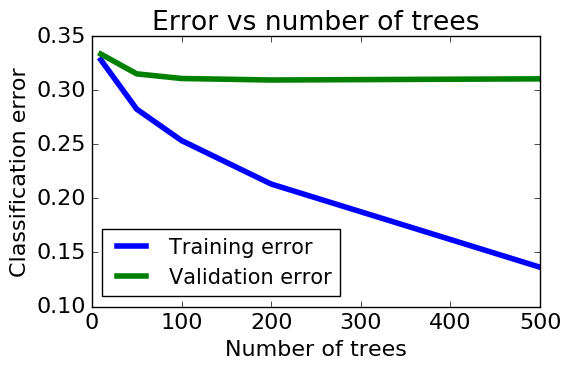

In [73]:
plt.plot([10, 50, 100, 200, 500], training_errors, linewidth=4.0, label='Training error')
plt.plot([10, 50, 100, 200, 500], validation_errors, linewidth=4.0, label='Validation error')

make_figure(dim=(10,5), title='Error vs number of trees',
            xlabel='Number of trees',
            ylabel='Classification error',
            legend='best')

As the number of trees increases, training error goes up but it is not the case for validation error!